In [1]:
import torch
from torchvision import transforms, datasets
import numpy as np

In [94]:
GPP_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [3]:
data_dir = "./dataset-resized"

In [77]:
data = datasets.ImageFolder(root=data_dir,transform = GPP_transform)

In [83]:
dataset_loader = torch.utils.data.DataLoader(data,
                                             batch_size=20, shuffle=True,
                                             num_workers=4)

In [6]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic',
           'trash']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

In [84]:
test_size =0.2
valid_size =0.1
num_train = len(data)
indices = list(range(num_train))
np.random.shuffle(indices)
split1  = int(np.floor(valid_size * num_train))
split2  = int(np.floor(test_size * num_train))

train_idx, valid_idx ,test_idx= indices[split1+split2:], indices[:split1],indices[split1:split1+split2]
#print(len(train_idx),split2,num_train)
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [10]:
test_size =0.21
num_test = len(valid_idx)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
valid_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [65]:
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [87]:
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle =True, #sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle =True, #sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle =True,
    num_workers=num_workers)

In [71]:
dataiter = iter(train_loader)
images, labels, *_ = dataiter.next()

In [82]:
data

Dataset ImageFolder
    Number of datapoints: 2527
    Root Location: ./dataset-resized
    Transforms (if any): Compose(
                             RandomSizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None

Traceback (most recent call last):
  File "C:\Users\jkcshop\Anaconda3\lib\multiprocessing\queues.py", line 232, in _feed
    close()
  File "C:\Users\jkcshop\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\jkcshop\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


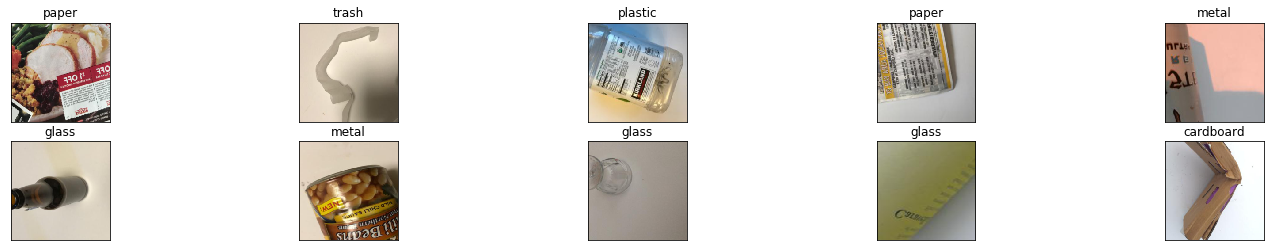

In [93]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 10 images
for i in np.arange(10):
    axs = fig.add_subplot(2, 10/2,i+1, xticks=[], yticks=[])
    imshow(images[i])
    axs.set_title(classes[labels[i]])

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [89]:
train_on_gpu = torch.cuda.is_available()

In [19]:
images[4].shape

(3, 224, 224)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 2, padding=1)
        # convolutional layer (sees 56x56x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 2, padding=1)
        # convolutional layer (sees 14x14x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 2, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(4, 4)
        self.pool1 = nn.MaxPool2d(2,2)
        # linear layer (64 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(64 * 7 * 7, 500)
        # linear layer (500 -> len(classes))
        self.fc2 = nn.Linear(500, len(classes))
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25)
)


In [21]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [90]:
# number of epochs to train the model
n_epochs = 8

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.712277 	Validation Loss: 1.707230
Validation loss decreased (inf --> 1.707230).  Saving model ...
Epoch: 2 	Training Loss: 1.708748 	Validation Loss: 1.703293
Validation loss decreased (1.707230 --> 1.703293).  Saving model ...
Epoch: 3 	Training Loss: 1.706541 	Validation Loss: 1.701617
Validation loss decreased (1.703293 --> 1.701617).  Saving model ...
Epoch: 4 	Training Loss: 1.701485 	Validation Loss: 1.696229
Validation loss decreased (1.701617 --> 1.696229).  Saving model ...
Epoch: 5 	Training Loss: 1.693273 	Validation Loss: 1.695827
Validation loss decreased (1.696229 --> 1.695827).  Saving model ...
Epoch: 6 	Training Loss: 1.686580 	Validation Loss: 1.678793
Validation loss decreased (1.695827 --> 1.678793).  Saving model ...
Epoch: 7 	Training Loss: 1.675195 	Validation Loss: 1.658784
Validation loss decreased (1.678793 --> 1.658784).  Saving model ...
Epoch: 8 	Training Loss: 1.658108 	Validation Loss: 1.647454
Validation loss decreased (1.65878

In [95]:
model.load_state_dict(torch.load('model_augmented.pt'))

In [96]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.648307

Test Accuracy of cardboard: 61% (249/403)
Test Accuracy of glass: 16% (85/501)
Test Accuracy of metal:  1% ( 5/410)
Test Accuracy of paper: 64% (384/594)
Test Accuracy of plastic:  8% (43/482)
Test Accuracy of trash:  0% ( 0/137)

Test Accuracy (Overall): 30% (766/2527)


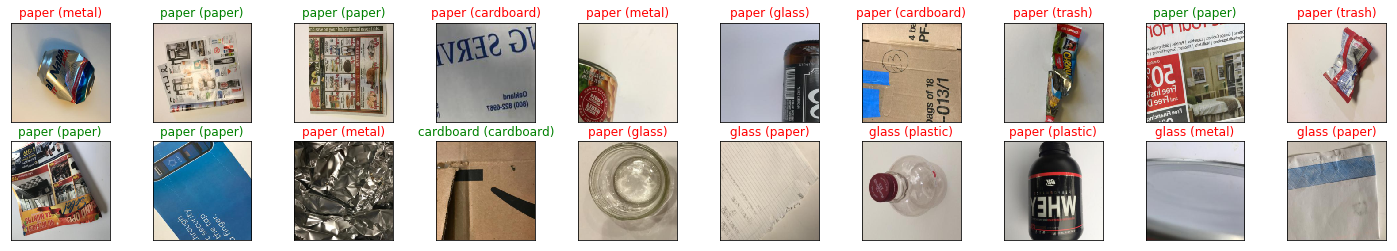

In [97]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))